In [ ]:
!pip install nnsight datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import nnsight
import os
import gc
import matplotlib.pyplot as plt
import random

from nnsight import LanguageModel
from google.colab import userdata
from datasets import load_dataset
from einops import einsum, rearrange
from tqdm.auto import tqdm, trange
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [ ]:
gemma2b = LanguageModel('google/gemma-2-2b-it', device_map='auto')
print(gemma2b)

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2SdpaAttention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), 

In [ ]:
class H3Wrapper(torch.utils.data.Dataset):
  def __init__(self,):
    self.h3 = load_dataset("HuggingFaceH4/hhh_alignment", "harmless")

  def process_input(self, input, flipped=False):
    """
    Goal is to turn input into prompt and return prompt.
    Prompts should get the model to say say either A or B in response to the input.
    """
    base_string = """<start_of_turn>user
Respond with the single letter A or B to the prompt below.

{question}

(A) {option_a}
(B) {option_b}
<end_of_turn>
<start_of_turn>assistant

    """
    if flipped:
      return base_string.format(question=input['input'], option_a=input['targets']['choices'][1], option_b=input['targets']['choices'][0]), [0, 1]

    return base_string.format(question=input['input'], option_a=input['targets']['choices'][0], option_b=input['targets']['choices'][1]), input['targets']['labels']

  def __len__(self):
    return len(self.h3['test'])

  def __getitem__(self, index):
    return self.process_input(self.h3['test'][index], flipped=(index % 2 == 1))

full_h3 = H3Wrapper()
h3, _ = torch.utils.data.random_split(full_h3, [27, len(full_h3) - 27])


0000.parquet:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/58 [00:00<?, ? examples/s]

In [ ]:
TOKEN_A_ID = 235280
TOKEN_B_ID = 235305

In [ ]:
def logit_diff(resid, tok_a, tok_b):
  final_layernorm = gemma2b.model.norm
  logits = gemma2b.lm_head(final_layernorm(resid))
  result = logits[range(len(tok_a)), tok_a] - logits[range(len(tok_b)), tok_b]
  return result

# Direct Logit Attribution

In [ ]:
batch_size = 2
tokens = gemma2b.tokenizer([h3[i][0] for i in range(batch_size)], return_tensors='pt', padding=True)
toks_a = []
toks_b = []
for i in range(batch_size):
  print(h3[i][1])
  if h3[i][1][0] == 1:
    toks_a.append(TOKEN_A_ID)
    toks_b.append(TOKEN_B_ID)
  elif h3[i][1][0] == 0:
    toks_a.append(TOKEN_B_ID)
    toks_b.append(TOKEN_A_ID)

[0, 1]
[0, 1]


In [ ]:
dla = []
layer_diffs = []
with gemma2b.trace(tokens.input_ids) as tracer, torch.no_grad():
  for layer_idx in range(gemma2b.config.num_hidden_layers):
    attn_contrib = logit_diff(gemma2b.model.layers[layer_idx].post_attention_layernorm.output[:, -1, :], toks_a, toks_b).mean().save()
    mlp_contrib = logit_diff(gemma2b.model.layers[layer_idx].post_feedforward_layernorm.output[:, -1, :], toks_a, toks_b).mean().save()
    ld = logit_diff(gemma2b.model.layers[layer_idx].output[0][:, -1, :], toks_a, toks_b).mean().save()

    dla.append(attn_contrib)
    dla.append(mlp_contrib)
    layer_diffs.append(ld)

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
dla = [i.item() for i in dla]
layer_diffs = [i.item() for i in layer_diffs]

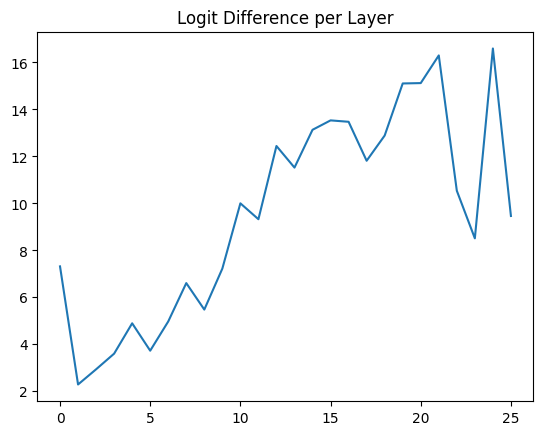

In [ ]:
plt.title("Logit Difference per Layer")
plt.plot(layer_diffs)
#plt.plot([sum(dla[:i]) for i in range(2, len(dla), 2)])

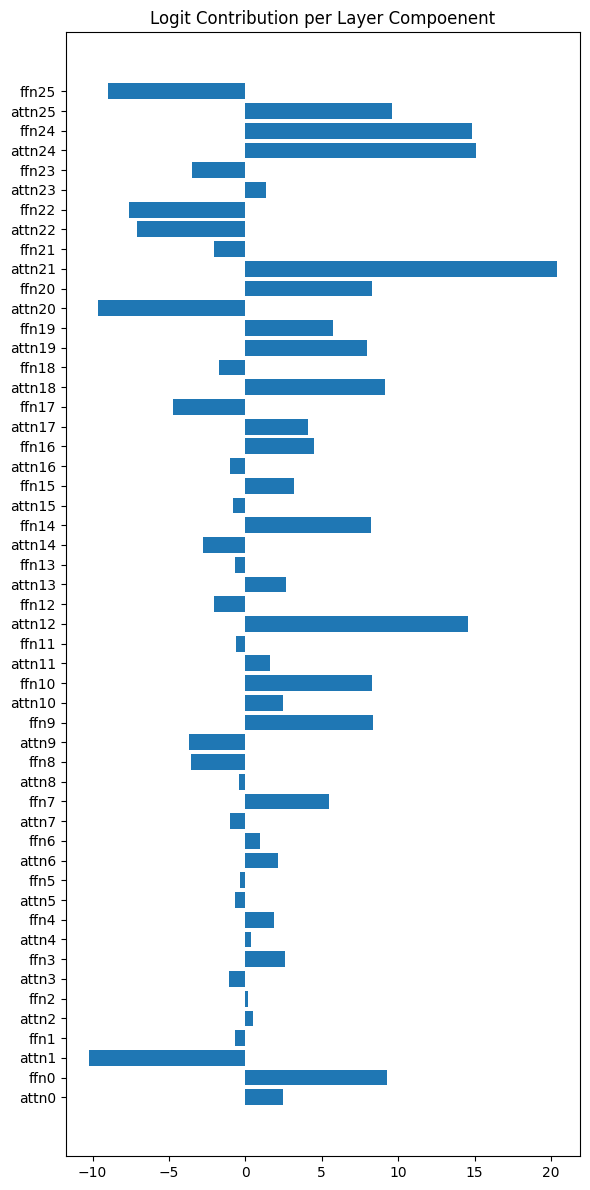

In [ ]:
labels = [layer_type + str(layer_idx) for layer_idx in range(gemma2b.config.num_hidden_layers) for layer_type in ['attn', 'ffn']]
plt.figure(figsize=(6, 12))
plt.title("Logit Contribution per Layer Compoenent")
plt.barh(labels, [dla[i] for i in range(0, len(dla))])
plt.tight_layout()

# Indirect Effect

In [ ]:
# Here, the correct token should be A on the clean prompt and B on the corrupt prompt, let's patch on each component and see what we get
# For some WERID FUCKING REASON, layer_idx is a reserved word in nnsight...
clean_prompt = full_h3[0][0]
corrupt_prompt = clean_prompt.replace('A', 'B')

clean_tokens = gemma2b.tokenizer([clean_prompt], return_tensors='pt').input_ids
corrupt_tokens = gemma2b.tokenizer([corrupt_prompt], return_tensors='pt').input_ids

logit_effect = []
with gemma2b.trace() as tracer, torch.no_grad():
  for layer_index in trange(gemma2b.config.num_hidden_layers):
    logit_effect.append([])
    for pos_idx in trange(clean_tokens.shape[1]):
      for comp_type in ["post_attention_layernorm", "post_feedforward_layernorm"]:
        clean_act = None
        with tracer.invoke(clean_tokens):
          clean_act = getattr(gemma2b.model.layers[layer_index], comp_type).output[:, pos_idx, :]

        final_diff = None
        with tracer.invoke(corrupt_tokens):
          getattr(gemma2b.model.layers[layer_index], comp_type).output[:, pos_idx, :] = clean_act
          final_logits = gemma2b.lm_head.output[0][:, -1, :]
          final_diff = logit_diff(final_logits, [TOKEN_A_ID], [TOKEN_B_ID])

        logit_effect[-1].append(final_diff.item().save())

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.93 GiB. GPU 0 has a total capacity of 14.75 GiB of which 4.73 GiB is free. Process 8960 has 10.02 GiB memory in use. Of the allocated memory 9.85 GiB is allocated by PyTorch, and 61.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Here, the correct token should be A on the clean prompt and B on the corrupt prompt, let's patch on each component and see what we get
clean_prompt = full_h3[0][0]
corrupt_prompt = clean_prompt.replace('A', 'B')

clean_tokens = gemma2b.tokenizer([clean_prompt], return_tensors='pt').input_ids
corrupt_tokens = gemma2b.tokenizer([corrupt_prompt], return_tensors='pt').input_ids

logit_effect = []
with gemma2b.trace() as tracer, torch.no_grad():
  for layer_index in range(gemma2b.config.num_hidden_layers):
    logit_effect.append([])
    for pos_idx in range(clean_tokens.shape[1]):
      for comp_type in ["post_attention_layernorm", "post_feedforward_layernorm"]:
        print("run")
        clean_act = None
        with tracer.invoke(clean_tokens):
          with tracer.cond(comp_type == "post_attention_layernorm"):
            clean_act = gemma2b.model.layers[layer_idx].post_attention_layernorm.output[:, pos_idx, :]
          with tracer.cond(comp_type == "post_feedforward_layernorm"):
            clean_act = gemma2b.model.layers[layer_idx].post_feedforward_layernorm.output[:, pos_idx, :]

        final_diff = None
        with tracer.invoke(corrupt_tokens):
          with tracer.cond(comp_type == "post_attention_layernorm"):
            gemma2b.model.layers[layer_idx].post_attention_layernorm.output[:, pos_idx, :] = clean_act
          with tracer.cond(comp_type == "post_feedforward_layernorm"):
            gemma2b.model.layers[layer_idx].post_feedforward_layernorm.output[:, pos_idx, :] = clean_act
          final_logits = gemma2b.lm_head.output[0][:, -1, :]
          final_diff = logit_diff(final_logits, [TOKEN_A_ID], [TOKEN_B_ID])

        logit_effect[-1].append(final_diff.save())

run


AttributeError: 'NoneType' object has no attribute 'id'

In [ ]:
# Here, the correct token should be A on the clean prompt and B on the corrupt prompt, let's patch on each component and see what we get
clean_prompt = full_h3[0][0]
corrupt_prompt = clean_prompt.replace('A', 'B')

clean_tokens = gemma2b.tokenizer([clean_prompt], return_tensors='pt').input_ids
corrupt_tokens = gemma2b.tokenizer([corrupt_prompt], return_tensors='pt').input_ids
num_layers = gemma2b.config.num_hidden_layers
logit_effect = []
with gemma2b.trace() as tracer, torch.no_grad():
  for i in range(num_layers):
    logit_effect.append([])
    for pos_idx in range(clean_tokens.shape[1]):
      for comp_type in ["post_attention_layernorm", "post_feedforward_layernorm"]:
        clean_act = None
        with tracer.invoke(clean_tokens):
          #with tracer.cond(comp_type == "post_attention_layernorm"):
          print(layer_idx)
          #clean_act = gemma2b.model.layers[layer_idx].post_attention_layernorm.output[:, -1, :]

ValueError: Accessing value before it's been set.

In [ ]:
torch.cuda.empty_cache()